In [ ]:
#### Packages ####
from pathlib import Path
from argparse import Namespace
from collections import Counter
import json
import os
import string
import time
import math
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd #just to open our file
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [12, 10]
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### Setting Direc
import os
os.chdir("/content/drive/My Drive/LMU-Statistik/SS22/WWC Hackathon for Social Good/wwcode-hackathon-2022/data")

## Fake News Classifier Model

Use Kaggle Dataset to train a fake news classifier for newspaper coverage.

train.csv: A full training dataset with the following attributes:
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable


In [ ]:
fn_train = pd.read_csv("fake-news/train.csv")
fn_test = pd.read_csv("fake-news/test.csv")

In [ ]:
fn_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
print("Shape of dataset ", fn_train.shape)
print("Columns ", fn_train.columns)
print("Missing values:\n", fn_train.isna().sum())

Shape of dataset  (20800, 5)
Columns  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
Missing values:
 id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [ ]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
# Drop rows with missing data
fn_train_no_na = fn_train.dropna(axis=0, how="any")
fn_train_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


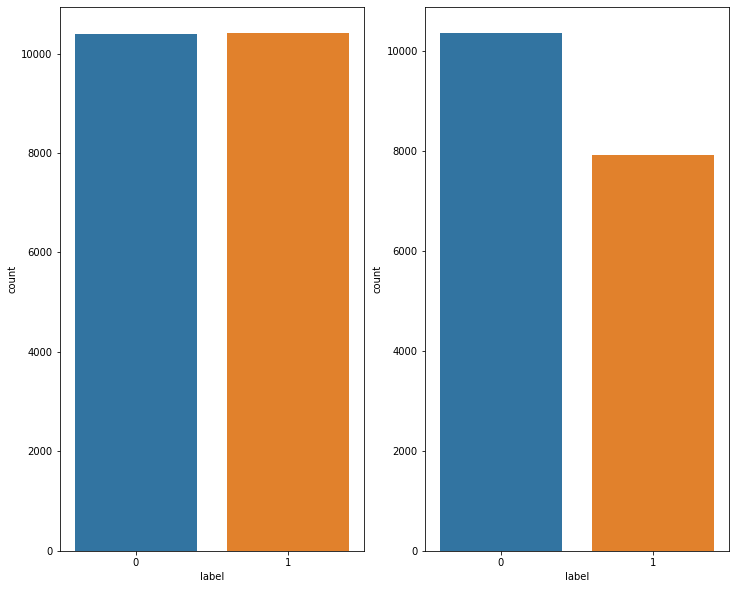

In [ ]:
# Check for class balance
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train, ax=ax1)
sns.countplot(x="label", data=fn_train_no_na, ax=ax2)
plt.show()

The is slight imbalance after removing the missing values which where mostly present in the 'unreliable' news. The ratio between 'fake' and 'reliable' went from 1:1 to 4:5.

In [ ]:
# Continue to work without missing data rows
fn_train.dropna(axis=0, how="any", inplace=True)

In [ ]:
# Check for duplicates
fn_train.drop_duplicates(subset=['title', 'text'], keep='first', inplace=True)

## Understand the structure and properties of articles classified as incredible/fake

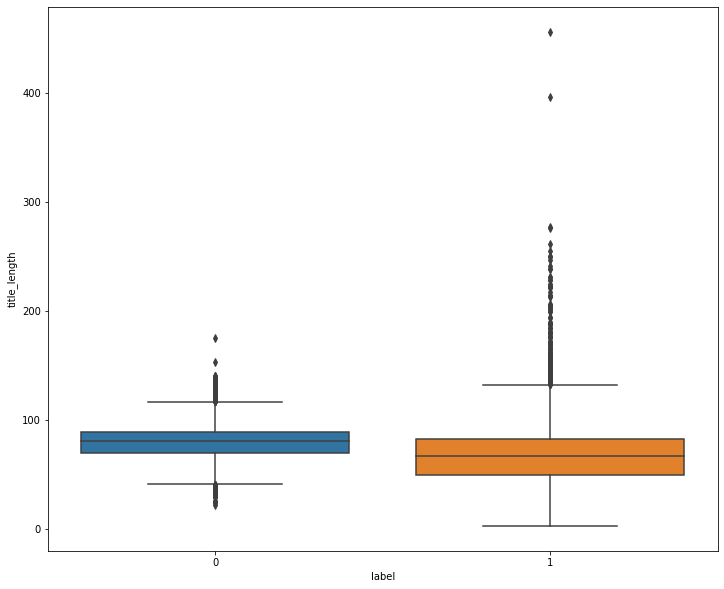

In [ ]:
# Inspecting the titles/headlines of the articles
fn_train['title_length'] = fn_train['title'].apply(lambda x: len(x))
sns.boxplot(y='title_length', x='label', data=fn_train)
plt.show()

The titles of credible news are mostly a bit longer than the ones of fake news, but there is an overlap in the IQRs and also the fake news have a lot of outliers upwards, but there are also some articles with really short titles, as the minimum in this category is visibly below the other's minimum. In general, we can say that the title lengths of fake news cover a larger range than the lengths of credible news.

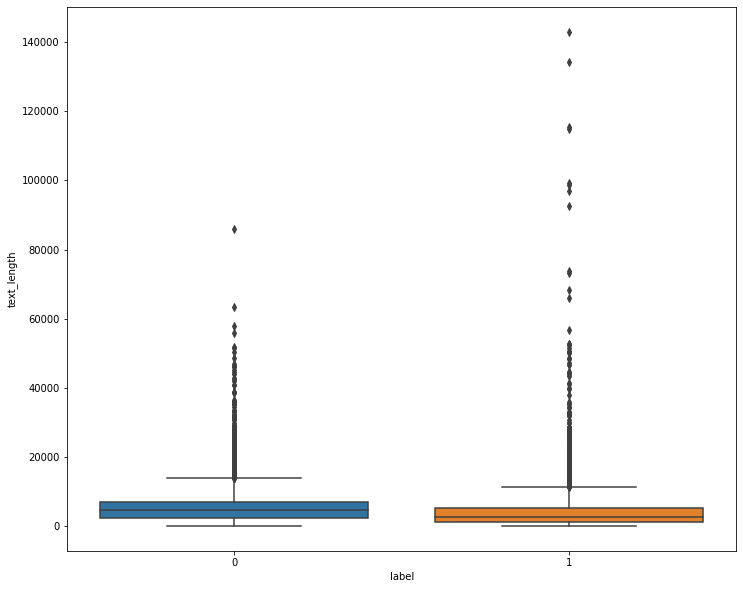

In [ ]:
# Inspecting the article lengths
fn_train['text_length'] = fn_train['text'].apply(lambda x: len(x))
sns.boxplot(y='text_length', x='label', data=fn_train)
plt.show()

The credible news seem to be a bit longer in general. The median and IQR lie above those for fake news. Both categories have a lot of outliers, though the outliers in fake news are spread out more towards really long articles with a length nearly twice as much as furthest outlier in the credible category.  
Both catories have a minimum at zero, that needs to be considered in further analysis and might count as missing data.

In [ ]:
fn_train.describe()

,id,label,title_length,text_length
count,18240.000000,18240.000000,18240.000000,18240.000000
mean,10404.168805,0.431963,74.752796,4792.746820
std,5998.790849,0.495363,22.635167,5218.173152
min,0.000000,0.000000,3.000000,1.000000
25%,5208.750000,0.000000,61.000000,1833.000000
50%,10415.500000,0.000000,76.000000,3689.000000
75%,15600.250000,1.000000,88.000000,6530.000000
max,20799.000000,1.000000,456.000000,142961.000000


The minimum length of a title is 3 and the minimum length of a text 1 character. That doesn't make much sense.

In [ ]:
fn_train[fn_train['title_length'] < 5]

,id,title,author,text,label,title_length,text_length
2561,2561,Wow!,Gillian,http://www.thepoliticalinsider.com/wikileaks-c...,1,4,1214
15728,15728,Rum,Kantucky,RIGHT REVERAND POPE JEREMIAH GOLDSTIEN says: \...,1,3,422
17081,17081,EPIC,Eric Odom,It didn’t take us long to think of a word to d...,1,4,2120


In [ ]:
fn_train[fn_train['text_length'] < 5]

,id,title,author,text,label,title_length,text_length
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1,26,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,91,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,72,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,98,1
592,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,,1,99,1
...,...,...,...,...,...,...,...
19857,19857,"A Fifth Clinton Presidency? Hill, No!",Michelle Malkin,,1,37,1
19929,19929,98% of public now ‘really looking forward’ to ...,NewsBiscuit,,1,100,1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,,1,78,1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,,1,73,1


The short titles convey a meaning, but the short texts can be counted as missing data.

In [ ]:
# Remove rows where text is empty
fn_train = fn_train[fn_train['text_length'] > 5]

In [ ]:
fn_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18166 entries, 0 to 20799
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            18166 non-null  int64 
 1   title         18166 non-null  object
 2   author        18166 non-null  object
 3   text          18166 non-null  object
 4   label         18166 non-null  int64 
 5   title_length  18166 non-null  int64 
 6   text_length   18166 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


75 rows were removed.

In [ ]:
fn_train.describe()

,id,label,title_length,text_length
count,18166.000000,18166.000000,18166.000000,18166.000000
mean,10405.655125,0.429704,74.771001,4812.266046
std,5997.178218,0.495047,22.604810,5219.802722
min,0.000000,0.000000,3.000000,9.000000
25%,5213.500000,0.000000,61.000000,1853.000000
50%,10417.500000,0.000000,76.000000,3709.000000
75%,15599.750000,1.000000,88.000000,6538.000000
max,20799.000000,1.000000,456.000000,142961.000000


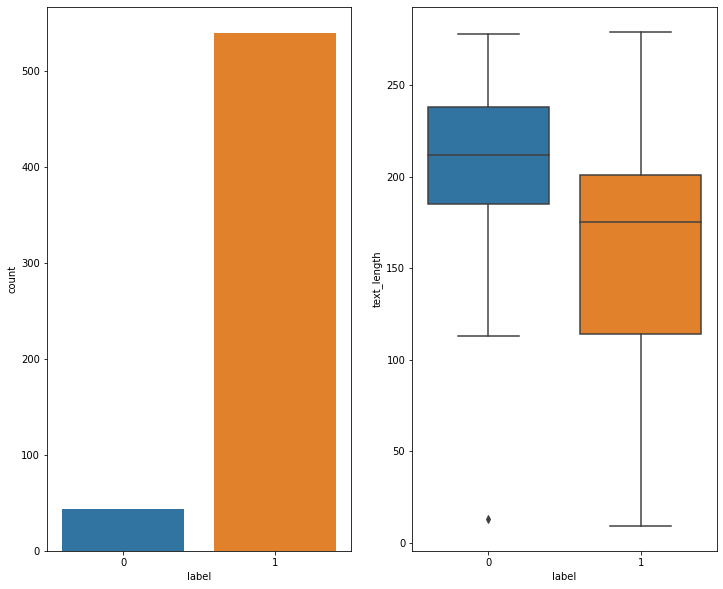

In [ ]:
# Look at shrt articles and their categories
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.countplot(x="label", data=fn_train[fn_train['text_length'] < 280], ax=ax1)
sns.boxplot(y='text_length', x='label', data=fn_train[fn_train['text_length'] < 280], ax=ax2)
plt.show()

Really short articles (same length as a tweet) are mostly found in the fake news category, but there are also some in the reliable news. 

In [ ]:
fn_train[(fn_train['text_length'] < 280) & (fn_train['label'] == 0)].head()

,id,title,author,text,label,title_length,text_length
81,81,Turkey Threatens to Open Migrant ’Land Passage...,Breitbart London,(AP) — Turkey’s minister in charge of Europ...,0,78,208
2349,2349,Serb Officials Warn Of Another War In The Balkans,Breitbart London,"BELGRADE, Serbia (AP) — Serbian officials w...",0,49,212
3030,3030,Jury Deadlocks in Bill Cosby Trial Mistrial De...,Breitbart News,"NORRISTOWN, Pa. (AP) — Bill Cosby’s trial o...",0,64,238
3076,3076,Muslims Protest with Street Prayer in Paris Su...,Breitbart London,PARIS (AP) — Hemmed in and closely watched ...,0,50,222
3651,3651,Italian Court Convicts Jihadists Plotting Rome...,Breitbart London,MILAN (AP) — An Italian court has convicted...,0,53,220


In [ ]:
fn_train[(fn_train['text_length'] < 280) & (fn_train['label'] == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 81 to 20685
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            44 non-null     int64 
 1   title         44 non-null     object
 2   author        44 non-null     object
 3   text          44 non-null     object
 4   label         44 non-null     int64 
 5   title_length  44 non-null     int64 
 6   text_length   44 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.8+ KB


The short articles in the reliable category seem to be subheadings of the actual articles. There are 44 of these in the training data. 

In [ ]:
# Check authors - are there common ones in both categories
gen_news_authors = set(list(fn_train[fn_train['label']==0]['author'].unique()))
fake_news_authors = set(list(fn_train[fn_train['label']==1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: ", len(gen_news_authors))
print("Number of distinct authors with fake articles: ", len(fake_news_authors))
print("Number of distinct authors with both genuine and fake: ", len(overlapped_authors))
print("List of overlapped authors", overlapped_authors)

Number of distinct authors with genuine articles:  2225
Number of distinct authors with fake articles:  1612
Number of distinct authors with both genuine and fake:  5
List of overlapped authors {'Pam Key', 'Ann Coulter', 'AFP', 'Pamela Geller', 'Reuters'}


## Pre-Processing

In [ ]:
#### Packages ####
#! pip install git+https://github.com/MCFreddie777/language-check.git # reqired for pycontractions
#! pip install pycontractions
! pip install nltk
! pip install unidecode
! pip install word2number

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MCFreddie777/language-check.git to /tmp/pip-req-build-zc4fu1pr
  Running command git clone -q https://github.com/MCFreddie777/language-check.git /tmp/pip-req-build-zc4fu1pr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 13.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5582 sha256=dfce6cdfd78fe85090f2d21723145f21b9e8765073f99b29576183f4bd9e806d
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bb

In [ ]:


# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re
import unidecode

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
import gensim.downloader as api
#from pycontractions import Contractions

In [ ]:
test_text = fn_train['text'][71]

In [ ]:
# Function to pre-process text
def preprocess_text(text):
  pass

In [ ]:
# Count exclamation point density
print(test_text.count('!'))
# Sentence length 
# use nltk sentence tokenizer

8


In [ ]:

# Removed urls, emojis and punctuations - Handling unicode characters - accented letters and some punctuation
def remove_urls(text):
  pass

def remove_emojis(text):
  pass

def remove_punctuation(text):
  pass

# Tokenization
# Removing stopwords
# Handling whitespace -> through tokenization
# Converting text to lowercase
# Expanding contractions (don't -> do not)
# Number words -> numeric - maybe?
# Stemming and/or Lemmatization
# British vs. American English

### Dealing with contractions - maybe later

In [ ]:
# downloads the model for expanding contractions
model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
re.findall(r"[a-zA-z]+\'[a-zA-z]+", test_text)

["Hillary's",
 "Hillary's",
 "Trump's",
 "Trump's",
 "Matthew's",
 "they're",
 "It's",
 "he'd",
 "Obama's",
 "Let's",
 "Kasich's",
 "Guevara's",
 "Cuba's",
 "don't",
 "O'Malley",
 "Russia's",
 "administration's",
 "don't",
 "NASA's",
 "Parenthood's",
 "Iran's",
 "government's",
 "can't",
 "Kerry's",
 "Mayor's",
 "America's",
 "We're",
 "director's",
 "Obama's",
 "won't",
 "Clinton's",
 "we'd",
 "Putin's",
 "Jackson's",
 "Obama's",
 "we've",
 "we're",
 "they're",
 "People's",
 "I'm",
 "he'd",
 "we're",
 "we're",
 "President's",
 "didn't",
 "won't",
 "wasn't",
 "gov't",
 "Biden's",
 "government's",
 "he'd",
 "Gosnell's",
 "media's",
 "lamb's",
 "world's",
 "Bloomberg's",
 "Krugman's",
 "they're",
 "can't",
 "Santa's",
 "religion's",
 "Rauf's",
 "Obama's",
 "gov't",
 "gov't",
 "don't",
 "It's",
 "Obama's",
 "Obama's",
 "Obama's",
 "gov't",
 "Obama's",
 "Earth's",
 "people's",
 "didn't",
 "People's",
 "Obama's"]

In [ ]:
### Text cleaning
### Expand contraction

cont = Contractions(kv_model=model)
text = list(cont.expand_texts([test_text], precise=True))
#print(test_text)
print(text)

#def expand_contraction(text):


['In Hillary\'s America, email server scrubs you \nObama transfers his Nobel Peace Prize to anti-Trump rioters \nDemocrats blame Hillary\'s criminal e-mail server for her loss, demand it face prison \nAfraid of "dangerous" Trump presidency, protesters pre-emptively burn America down to the ground \nClinton Foundation in foreclosure as foreign donors demand refunds \nHillary Clinton blames YouTube video for unexpected and spontaneous voter uprising that prevented her inevitable move into the White House \nSudden rise in sea levels explained by disproportionately large tears she would by climate scientists in the aftermath of Trump\'s electoral victory \nFBI director Comey delighted after receiving Nobel Prize for Speed Reading (650,000 emails in one week) \nU.N. deploys troops to American college campuses in order to combat staggeringly low rape rates \nResponding to Trump\'s surging poll numbers, Obama preemptively pardons himself for treason \nFollowing hurricane Matthew\'s failure to

In [ ]:
re.findall(r"[a-zA-z]+\'[a-zA-z]+", text[0])

["Hillary's",
 "Hillary's",
 "Trump's",
 "Trump's",
 "Matthew's",
 "Obama's",
 "Kasich's",
 "Guevara's",
 "Cuba's",
 "O'Malley",
 "Russia's",
 "administration's",
 "NASA's",
 "Parenthood's",
 "Iran's",
 "government's",
 "Kerry's",
 "Mayor's",
 "America's",
 "director's",
 "Obama's",
 "Clinton's",
 "Putin's",
 "Jackson's",
 "Obama's",
 "People's",
 "President's",
 "gov't",
 "Biden's",
 "government's",
 "Gosnell's",
 "media's",
 "lamb's",
 "world's",
 "Bloomberg's",
 "Krugman's",
 "Santa's",
 "religion's",
 "Rauf's",
 "Obama's",
 "gov't",
 "gov't",
 "Obama's",
 "Obama's",
 "Obama's",
 "gov't",
 "Obama's",
 "Earth's",
 "people's",
 "People's",
 "Obama's"]